# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# проверим количество пропусков в датасете
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace('$', '')
        row = row.replace(',00', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan   
    
    
df['balance'] = df['balance'].apply(make_convert)


In [7]:
# вычисли среднее значения признака balance
display(round(df['balance'].mean(), 3))

1529.129

### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
display(round(df['balance'].mean(), 3))

1526.936

### Задание 5

In [9]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
def get_nan(features):
    if features != 'unknown':
        return features
    else:
        return np.nan
    

# преобразуем строки 'unknown' to NaN
df['job'] = df['job'].apply(get_nan)
df['education'] = df['education'].apply(get_nan)


# Создадим словарь для замены значений на моду
values = {
    'job': df['job'].mode()[0],
    'education': df['education'].mode()[0]
}

# Заполним пропуски 

df = df.fillna(values)

df_popular = df[(df['job']== 'management') & (df['education'] == 'secondary')]
display(round(df_popular['balance'].mean(), 3))

1598.883

Альтернативный более короткий вариант данного решения ниже

In [10]:
# # Зададим моду для каждого признака чтобы заменить значения unknown
# mode_edu = df['education'].mode()[0]

# mode_job = df['job'].mode()[0]

# # ЗАменим пропуски на моду
# df['job'] = df['job'].apply(lambda x: mode_job if x == 'unknown' else x)
# df['education'] = df['education'].apply(lambda x: mode_edu if x == 'unknown' else x)
# # Зададим маску для нахождения баланса
# df_popular = df[(df['job']== 'management') & (df['education'] == 'secondary')]
# display(round(df_popular['balance'].mean(), 3))

### Задание 6

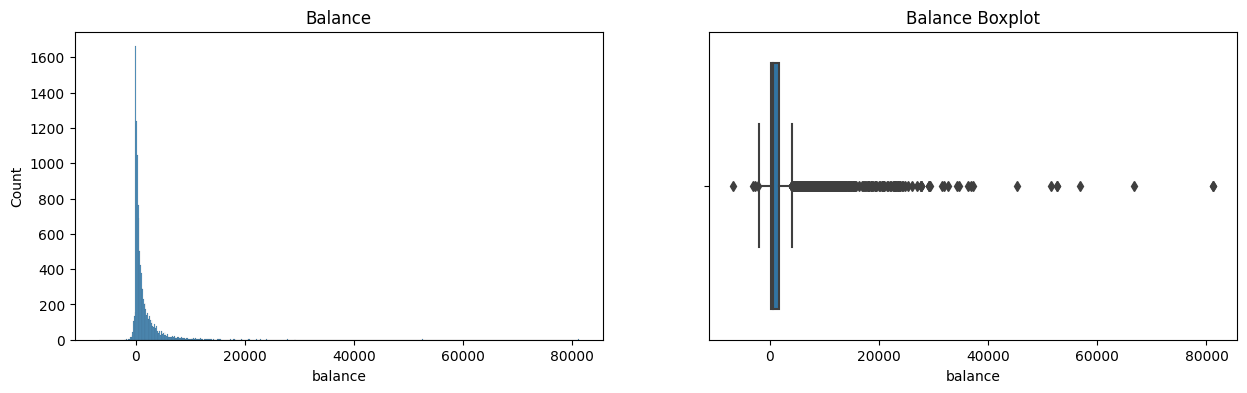

In [11]:
# удалите все выбросы для признака balance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Balance');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

In [12]:
def outliers_iqr (data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print(lower_bound, upper_bound)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

-2241.0 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


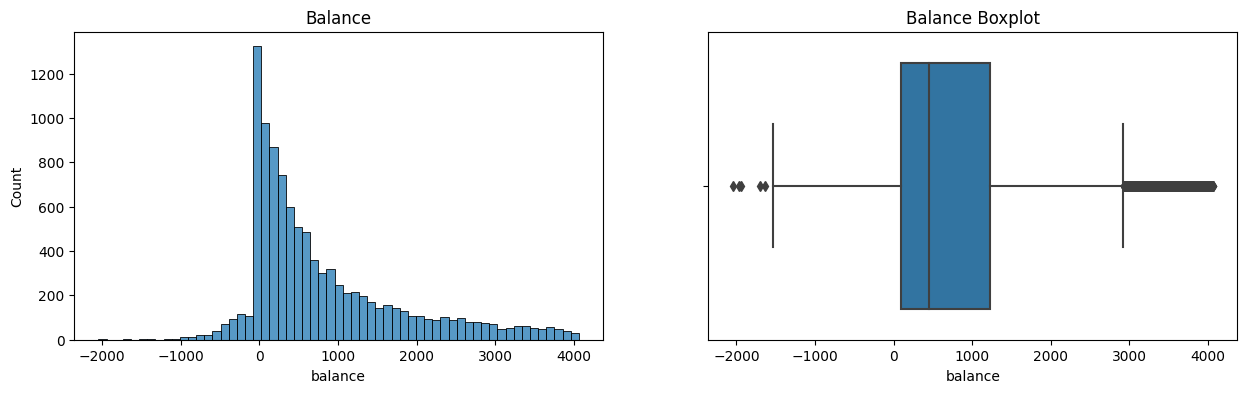

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Balance');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

## Часть 2:  Разведывательный анализ

### Задание 1

In [14]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
import plotly
import plotly.express as px

bars = cleaned['deposit'].value_counts()
fig = px.bar(
    data_frame=bars,
    title='Число клиентов открывших/неоткрывших депозит',
    height=400
)
fig.show()

### Задания 2 и 3

In [15]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
import statistics
from plotly.subplots import make_subplots
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = cleaned.dtypes
num_features = list(types[(types != 'object')].index)

fig = px.box(
    data_frame=cleaned,
    x=num_features,
    title='Статистические показатели в числовых признаках'
)
fig.update_layout(xaxis_title= 'Значение')
fig.show()

### Задания 4 и 5

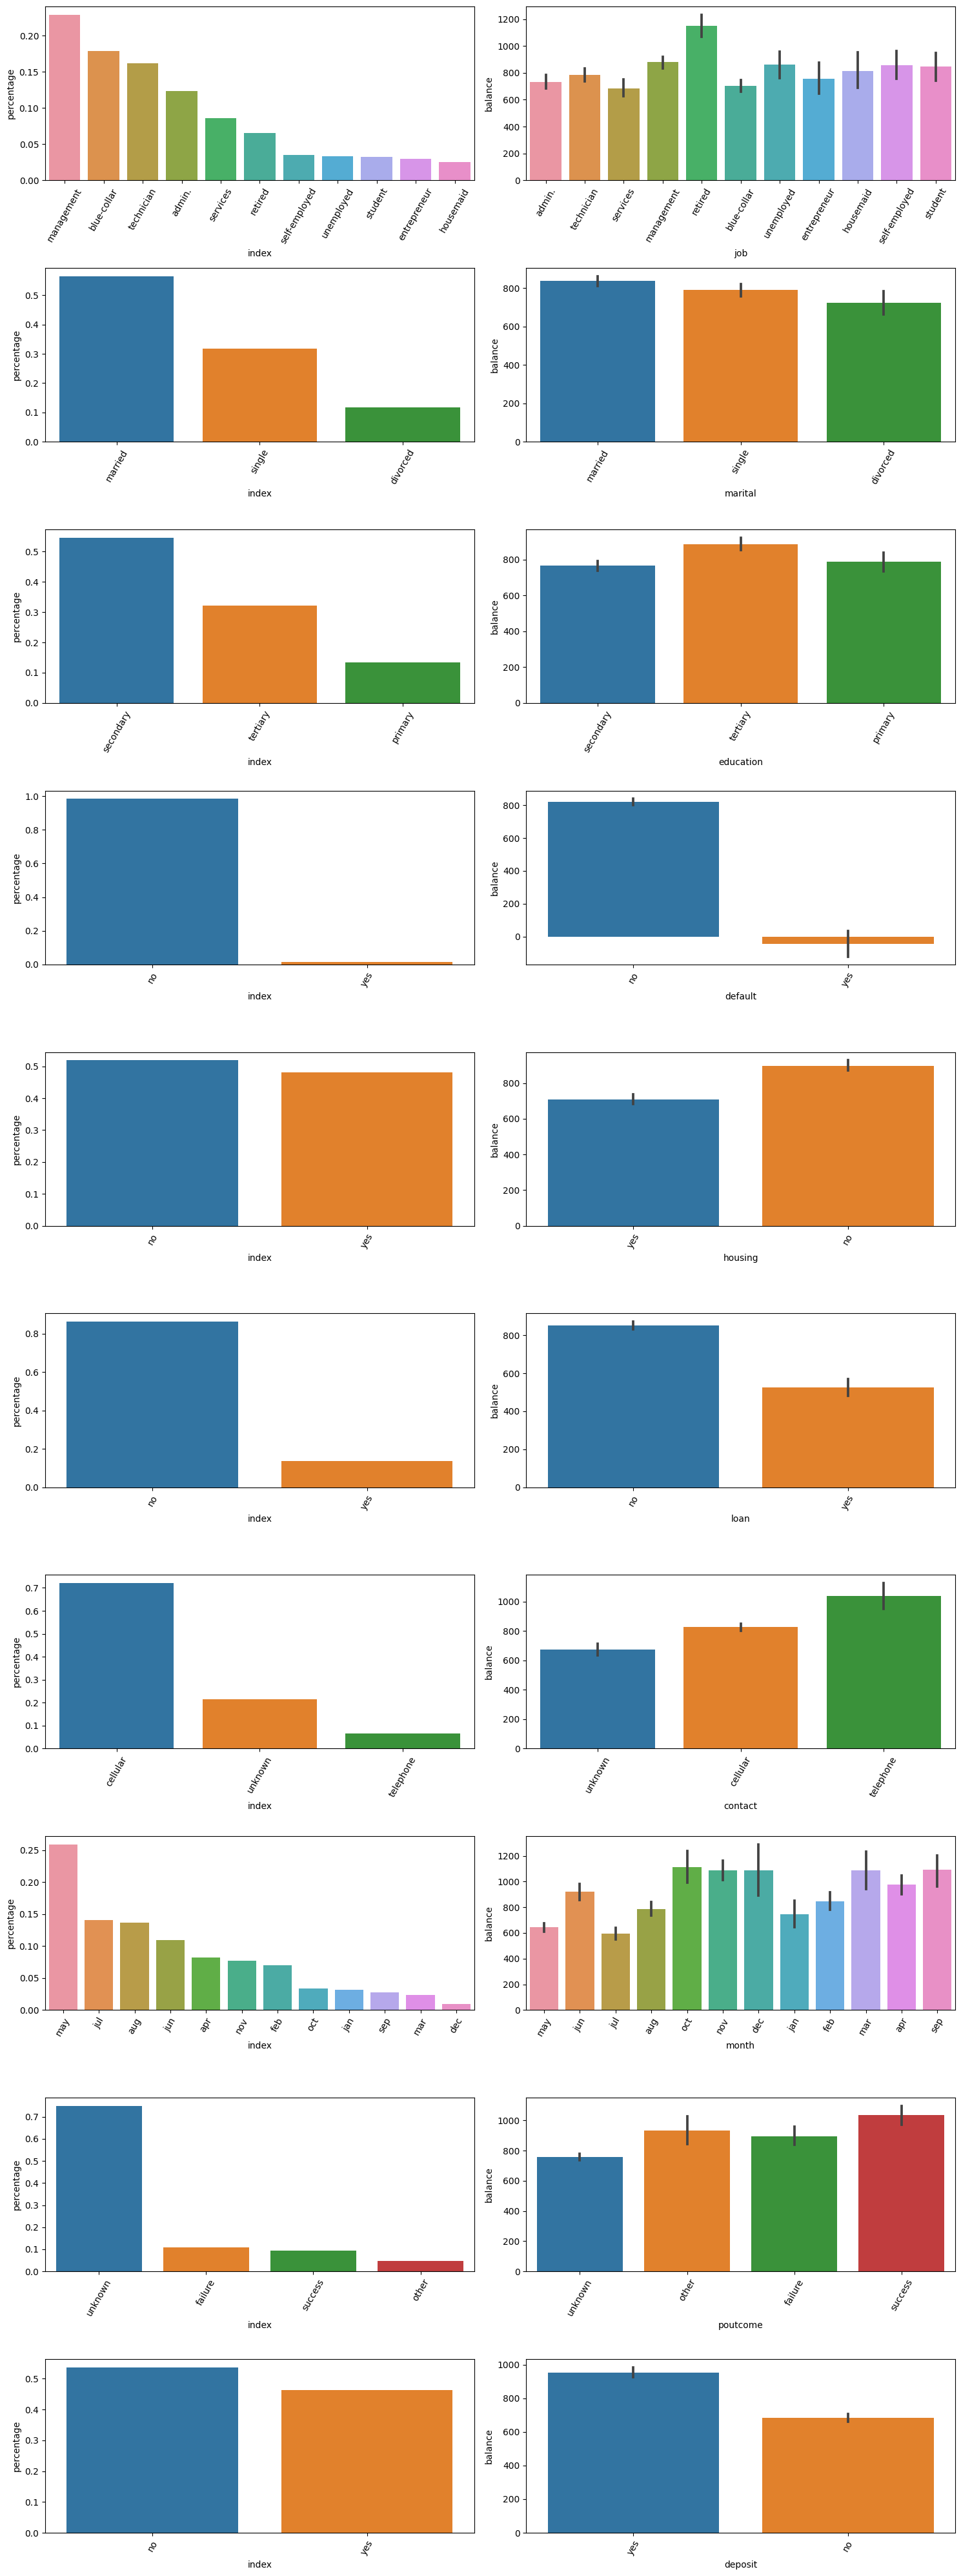

In [16]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
# создадим визуализацию для категориальных признаков
types = cleaned.dtypes
cat_features = list(types[(types == 'object')].index)

n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) # фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (cleaned[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x= 'index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму среднего баланса счета в зависимости от категории клиента
    mean_barplot = sns.barplot(data=cleaned, x=feature, y='balance', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

Исходя из представленных выше визуализаций можно сделать следующие выводы:
- относительно числовых признаков, можно сделать вывод, что в некоторых из них есть выбросы, хоть и не большое количество(в продолжительности разговора, так как максимальное значение составляет 64 минуты), также видно что существуют клиенты с которыми не разу не было связи в момент маркетинговых компаний.
- относительно категориальных, наглядно видны зависимости людей и их балансом в банке, так видно что большенство клиентов имеют высшее образование, женаты, не имеют просрочек по кредитам, имеют хорошую работу, не имеют кредиты на личные нужды, и видно что противопложные категории, имеют меньший баланс на счете.

### Задание 6

In [17]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# Сгрупируем по значениям прошлой компании без учета индексов и посчитаем значения текушей компании
df_deposit = cleaned.groupby('poutcome', as_index = False)['deposit'].value_counts()
fig = px.bar(
    data_frame=df_deposit,
    x='poutcome',
    y= 'count',
    color= 'deposit',
    title='Сравнения клиенто открывших депозит в прошлой компании и текушей ',
    height=600
)
fig.show()



### Задание 7

In [18]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df_deposit = cleaned.groupby('month', as_index = False)['deposit'].value_counts()
fig = px.bar(
    data_frame=df_deposit,
    x='month',
    y= 'count',
    color= 'deposit',
    barmode="group", # разделим на разные столбцы
    title='Сравнения клиенто открывших депозит в разрезе месяцев',
    height=600
)
fig.update_layout(
    yaxis_title="Количество клиентов",
    xaxis_title="Месяц открытия"
)
fig.show()

### Задание 8

In [19]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned['age_group'] = pd.cut(cleaned.age, [0, 30, 40, 50, 60, 2000], labels=['<30', '30-40', '40-50', '50-60', '60+'])

df_age = cleaned.groupby('age_group', as_index = False)['deposit'].value_counts()
fig = px.bar(
    data_frame=df_age,
    x='age_group',
    y= 'count',
    color= 'deposit',
    barmode="group", # разделим на разные столбцы
    title='Сравнения клиентов по возрасту открывших депозит',
    height=600
)
fig.update_layout(
    yaxis_title="Количество клиентов",
    xaxis_title="Возраст"
)
fig.show()

### Задания 9 и 10

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df_marital = cleaned.groupby('marital', as_index = False)['deposit'].value_counts()
fig = px.bar(
    data_frame=df_marital,
    x='marital',
    y= 'count',
    color= 'deposit',
    barmode="group", # разделим на разные столбцы
    title='Сравнения клиентов открывших депозит от семейного статуса',
    height=600
)
fig.update_layout(
    yaxis_title="Количество клиентов",
    xaxis_title="Cтатус семейного положения"
)
fig.show()


In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
df_education = cleaned.groupby('education', as_index = False)['deposit'].value_counts()
fig = px.bar(
    data_frame=df_education,
    x='education',
    y= 'count',
    color= 'deposit',
    barmode="group", # разделим на разные столбцы
    title='Сравнения клиентов открывших депозит от образования',
    height=600
)
fig.update_layout(
    yaxis_title="Количество клиентов",
    xaxis_title="Образование"
)
fig.show()

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
df_job = cleaned.groupby('job', as_index = False)['deposit'].value_counts()
fig = px.bar(
    data_frame=df_job,
    x='job',
    y= 'count',
    color= 'deposit',
    barmode="group", # разделим на разные столбцы
    title='Сравнения клиентов открывших депозит от вида профессиональной занятости',
    height=600
)
fig.update_layout(
    yaxis_title="Количество клиентов",
    xaxis_title="Профессиональная занятость"
)
fig.show()

Из построенных графиков, можно сделать вывод о том, что чаще всего депозиты открывают люди, которые не замужем/женаты, не имеют среднего или вышего образования и не имеют постоенного дохода (студенты и нетрудоспособные). То есть каще всего депозит открывают люди у которых нет постоянного высокого дохода, в связи с чем им чаще нужны инве средства полученные не от основного вида деятельности.

### Задание 11

In [23]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Выберем интересующих нас клиентов, а именно открывших депозит
df_agreed = cleaned[cleaned['deposit'] == 'yes']
# Сгруппируем данные по образованию и статусу семьи 
df_pivot = df_agreed.groupby(['education', 'marital'], as_index= False)['deposit'].value_counts()
#СОздадим сводную таблицу для визуализации
df_pivot_red = df_pivot.pivot_table(
    values='count',
    columns='education',
    index = 'marital'
)
fig = px.imshow(
    df_pivot_red,
    text_auto=True,
    title= 'Соотношение клиентов открывших депозит в разрезе семейный статус/образование',
    labels=dict(
        x = 'Образование',
        y = 'Статус семьи',
        color = 'Количество клиентов'
    )
)
fig.show()

### Дополнительные сведения для EDA

In [24]:
# Посмотрим на число клиентов и их соотношение в разре способа связи с клиентом
df = cleaned.groupby('contact', as_index=False)['deposit'].value_counts()

fig = px.bar(
    data_frame=df,
    x='contact',
    y= 'count',
    color= 'deposit',
    barmode="group", # разделим на разные столбцы
    title='Сравнения клиентов открывших депозит от способа связи',
    height=600
)
fig.update_layout(
    yaxis_title="Количество клиентов",
    xaxis_title="Вид контакта с клиентом"
)
fig.show()

Из представленного графика мы видим что основная масса обзванивается по средствам сотовой связи, и по соотношению людей оформивших депосит, можно сделать вывод, что при правильном контакте с человеком при личном обшении, это во многом преимущество для оформления депозита.

In [25]:
df_hist = df_agreed.groupby(['default','housing', 'loan'], as_index=False)['deposit'].value_counts().sort_values('count', ascending=False)
df_hist

,default,housing,loan,deposit,count
0,no,no,no,yes,2710
2,no,yes,no,yes,1475
3,no,yes,yes,yes,244
1,no,no,yes,yes,200
6,yes,yes,no,yes,22
4,yes,no,no,yes,15
5,yes,no,yes,yes,8
7,yes,yes,yes,yes,7


Из представленной таблицы где мы видим число клиентов согласившихся на депозит, большенство из них не имеет иных кредитов. В связи с чем не имеют иной кредитной нагрузки

## Часть 3: преобразование данных

### Задание 1

In [26]:
# Создадим копию датасета до преобразований признаков
data_cleaned = cleaned

In [27]:
# преобразуйте уровни образования
encoder = LabelEncoder()
data_cleaned['education'] = encoder.fit_transform(data_cleaned['education'])
data_cleaned['education'].sum()

11995

### Задания 2 и 3

In [28]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Создадим класс кодировшика для преобразования признака возраста
from category_encoders import OrdinalEncoder, OneHotEncoder
le = LabelEncoder()
data_cleaned["age_group"] = le.fit_transform(data_cleaned["age_group"])
# Создадим безимянные функции для преобразования бинарных признаков
data_cleaned['deposit'] = data_cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
print(round(data_cleaned['deposit'].std(), 3))
data_cleaned['default'] = data_cleaned['default'].apply(lambda x: 1 if x == 'yes' else 0)
data_cleaned['housing'] = data_cleaned['housing'].apply(lambda x: 1 if x == 'yes' else 0)
data_cleaned['loan'] = data_cleaned['loan'].apply(lambda x: 1 if x == 'yes' else 0)

# Посчитаем cреднее арефмитическое
print(round((data_cleaned['default'].mean() + data_cleaned['housing'].mean() + data_cleaned['loan'].mean()), 3))

0.499
0.635


### Задание 4

In [29]:
# создайте дамми-переменные
dummy_data = pd.get_dummies(data_cleaned)
dummy_data.shape[1]

46

### Задания 5 и 6

Наиболее высокая корреляция между признаками:


,level_0,level_1,0
1361,contact_unknown,contact_cellular,0.837885
459,pdays,poutcome_unknown,0.824031
1176,marital_married,marital_single,0.779038
505,previous,poutcome_unknown,0.628346
1941,poutcome_failure,pdays,0.608719
2112,poutcome_unknown,poutcome_failure,0.606736
2069,poutcome_success,poutcome_unknown,0.555044
18,age,job_retired,0.545524
63,education,job_management,0.518735
424,pdays,previous,0.513708


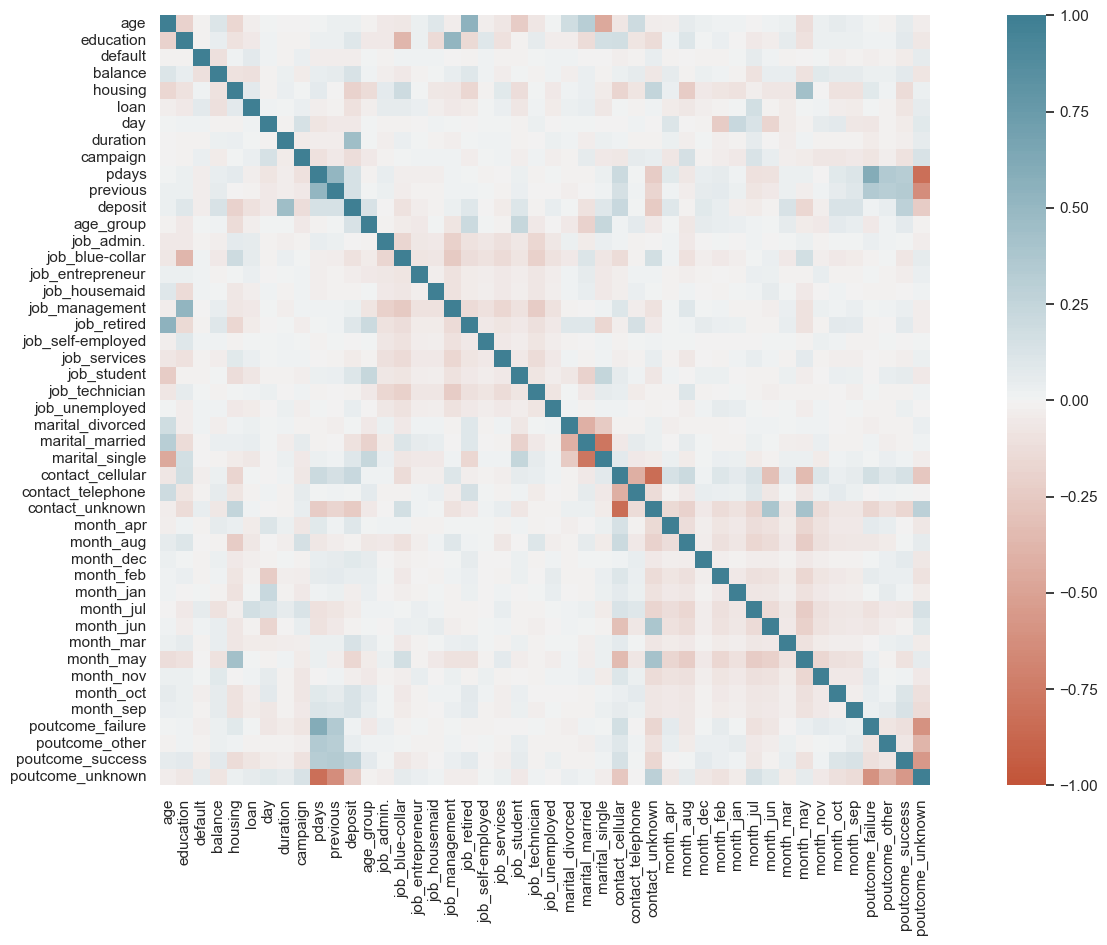

In [30]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = dummy_data.corr()
sns.set(rc={'figure.figsize':(20, 10)})
ax = sns.heatmap(
    corr, 
    vmin=-1, 
    vmax=1, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
);
print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending=False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
corr_unstack.iloc[:20, :]

In [31]:
# Создадим новый df для распределения корреляции относительно целевого признака
corr_n = abs(corr['deposit']).reset_index().sort_values('deposit', ascending=False)

corr_n['deposit'] = corr_n['deposit'].apply(lambda x: abs(x))
fig = px.bar(
    data_frame=corr_n,
    x = 'index',
    y= 'deposit',
    title= ' Распределение корреляции относительно целевого признака'
)
fig.show()


### Задания 7 и 8

In [32]:
X = dummy_data.drop(['deposit'], axis=1)
y = dummy_data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [33]:
# рассчитайте необходимые показатели
print(X_test.shape)
print(round(y_test.mean(), 2))

(3335, 45)
0.46


### Задание 9

In [34]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=15) # первым передается статистический метод, и количество нужных признаков
X_train_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.fit_transform(X_test, y_test)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'job_retired', 'contact_cellular', 'contact_unknown',
       'month_mar', 'month_may', 'month_oct', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [35]:
X_test_new.shape

(3335, 15)

### Задание 10

In [36]:
dummy_data = dummy_data[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_group', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = dummy_data.drop(['deposit'], axis=1)
y = dummy_data['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [37]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
# нормализуем
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(round(X_test_scaled[:, 0].mean(),2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [38]:
# обучите логистическую регрессию и рассчитайте метрики качества
# инициируем модель логистической регрессии
log_reg_model = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)
#Обучаем модель
log_reg_model.fit(X_train_scaled, y_train)

# Делаем предсказания для тестовой и тренировочной выборки
y_train_pred = log_reg_model.predict(X_train_scaled)
y_test_pred = log_reg_model.predict(X_test_scaled)

# Проверим метрики 
print(metrics.classification_report(y_test, y_test_pred))
print(metrics.classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770



### Задания 2,3,4

In [39]:
# обучите решающие деревья, настройте максимальную глубину
# Инициализируем модель решающего дерева
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42)
#Обучаем модель
dt.fit(X_train_scaled, y_train)

# Делаем предсказания для тестовой и тренировочной выборки
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

# Проверим метрики 
print(metrics.accuracy_score(y_test, y_test_pred))
print(metrics.accuracy_score(y_train, y_train_pred))


0.7487256371814093
1.0


In [40]:
# Инициализируем модель решающего дерева
dt = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42, max_depth=6)
#Обучаем модель
dt.fit(X_train_scaled, y_train)

# Делаем предсказания для тестовой и тренировочной выборки
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)

# Проверим метрики 
print(metrics.accuracy_score(y_test, y_test_pred))
print(metrics.accuracy_score(y_train, y_train_pred))

0.8065967016491754
0.8180206794682422


### Задание 5

In [41]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

grid_search_tree = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)
%time 
grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 0 ns
Wall time: 0 ns
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [49]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
# Обучим модель
rf.fit(X_train_scaled, y_train)

# Сделаем предсказания
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

# Проверим метрики 
print(metrics.classification_report(y_test, y_test_pred_rf))
print(metrics.classification_report(y_train, y_train_pred_rf))
print('Test recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred_rf)))



              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Test recall: 0.83


### Задания 2 и 3

In [50]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
# Обучим модель
gb.fit(X_train_scaled, y_train)

# найдем метрики
y_train_pred_gb = gb.predict(X_train_scaled)
y_test_pred_gb = gb.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred_gb))
print(metrics.classification_report(y_train, y_train_pred_gb))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770



### Задание 4

In [51]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# Инициализируем модели 
estimator = [
    ('lr', linear_model.LogisticRegression(solver='sag', random_state=42)),
    ('dt', tree.DecisionTreeClassifier(
        criterion = 'entropy', 
        random_state=42, 
        min_samples_leaf=5, 
        max_depth=6
        )
     ),
    ('gb', ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
))
]

# Создаем объект класса стекинг
reg = ensemble.StackingClassifier(
    estimators=estimator,
    final_estimator=linear_model.LogisticRegression(random_state=42))

# Обучаем модель
reg.fit(X_train_scaled, y_train)

# Предскажем значения на тестовой выборке

y_test_pred_reg = reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred_reg))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

Feature: 0, Score: 0.05795
Feature: 1, Score: 0.04773
Feature: 2, Score: 0.50711
Feature: 3, Score: 0.01478
Feature: 4, Score: 0.05515
Feature: 5, Score: 0.00836
Feature: 6, Score: 0.03990
Feature: 7, Score: 0.00360
Feature: 8, Score: 0.07261
Feature: 9, Score: 0.02782
Feature: 10, Score: 0.01521
Feature: 11, Score: 0.01988
Feature: 12, Score: 0.01353
Feature: 13, Score: 0.11496
Feature: 14, Score: 0.00143


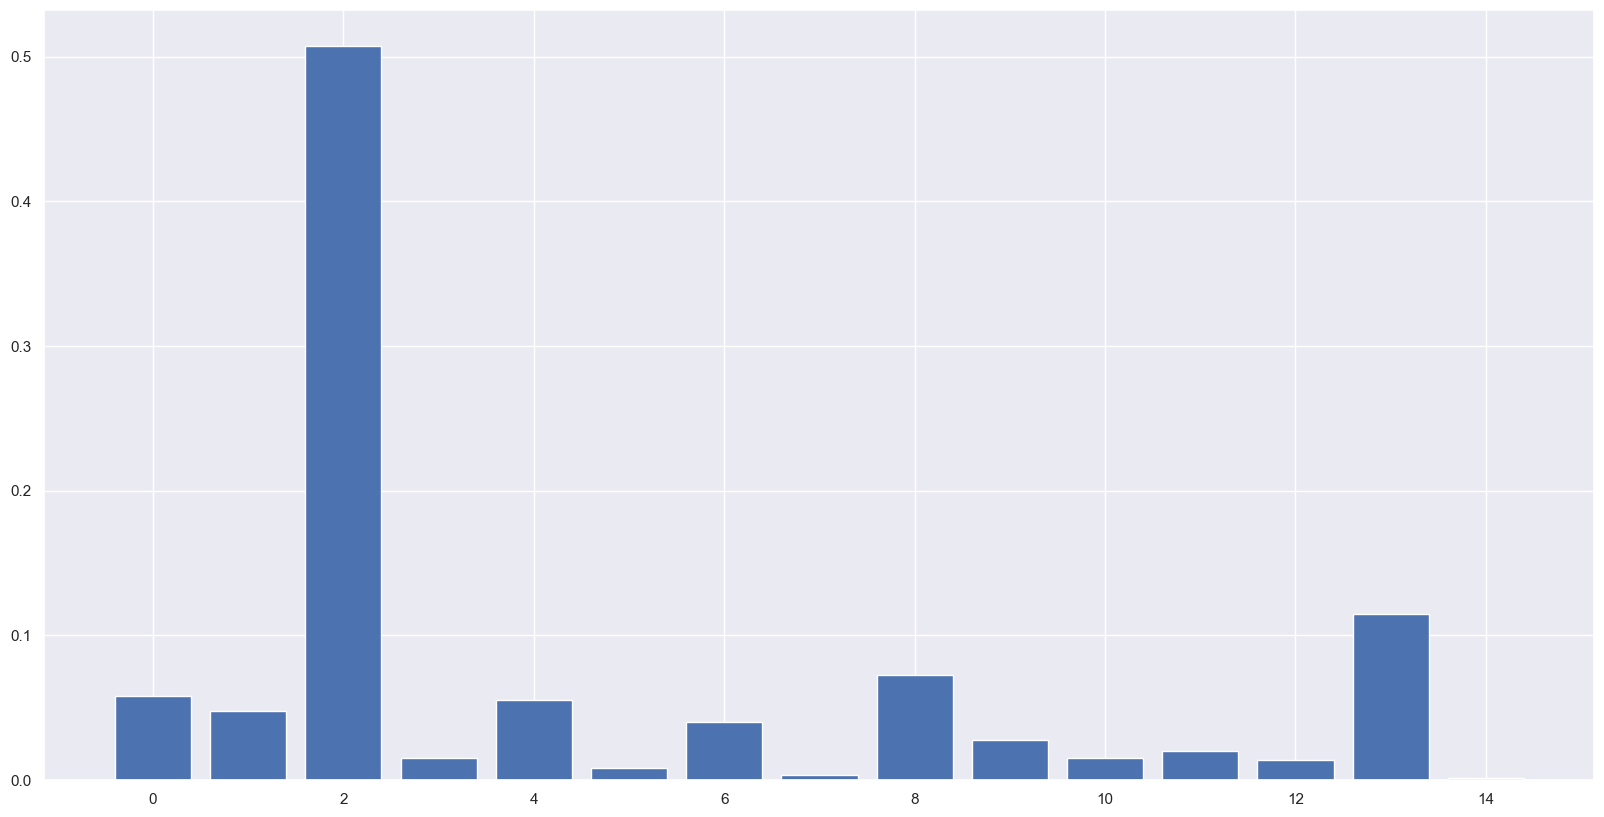

In [59]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# сотстав признаков ['balance', 'housing', 'duration', 'campaign', 'pdays', 
#          'previous', 'age_group', 'contact_cellular', 'contact_unknown',
#          'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown'
importance = gb.feature_importances_
for i,v in enumerate(importance):
  print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()


### Задания 6,7,8

In [62]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
random_state =42
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state,
                                          n_jobs=-1)
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score

%time

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", 
                            direction="maximize") 
                            #storage='sqlite:///ex.db', 
                            # load_if_exists=True)
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20, n_jobs=-1)

[I 2023-05-14 20:47:35,825] A new study created in memory with name: RandomForestClassifier


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-05-14 20:47:46,897] Trial 9 finished with value: 0.8689396309039724 and parameters: {'n_estimators': 104, 'max_depth': 16, 'min_samples_leaf': 4}. Best is trial 9 with value: 0.8689396309039724.
[I 2023-05-14 20:47:47,010] Trial 4 finished with value: 0.8828320802005013 and parameters: {'n_estimators': 110, 'max_depth': 16, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.8828320802005013.
[I 2023-05-14 20:47:47,034] Trial 7 finished with value: 0.844773299748111 and parameters: {'n_estimators': 112, 'max_depth': 17, 'min_samples_leaf': 10}. Best is trial 4 with value: 0.8828320802005013.
[I 2023-05-14 20:47:47,043] Trial 8 finished with value: 0.867145983119725 and parameters: {'n_estimators': 131, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 4 with value: 0.8828320802005013.
[I 2023-05-14 20:47:47,099] Trial 2 finished with value: 0.8602654176424669 and parameters: {'n_estimators': 137, 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 4 with value: 0.8828

In [63]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82
